In [1]:
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
import random

def set_random_seed(seed_value):
    """Set the random seed for reproducibility."""
    random.seed(seed_value)  # Set the seed for Python's random module
    np.random.seed(seed_value)  # Set the seed for NumPy
    torch.manual_seed(seed_value)  # Set the seed for PyTorch CPU
    torch.cuda.manual_seed(seed_value)  # Set the seed for PyTorch
    torch.cuda.manual_seed_all(seed_value)  # Set the seed for all GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on GPU
    torch.backends.cudnn.benchmark = False  # Turn off benchmarks for reproducibility

# Set a specific random seed value (e.g., 42)
set_random_seed(42)

In [3]:
# Load the data
def load_data():
    reviews = pd.read_pickle('../Pickle/reviews.pkl')
    books = pd.read_pickle('../Pickle/books.pkl')
    read = pd.read_pickle('../Pickle/read.pkl')
    user_genres = pd.read_pickle('../Pickle/user_most_common_genres.pkl')
    review_embeddings = pd.read_pickle('../Pickle/review_embeddings.pkl')
    review_sentiment = pd.read_pickle('../Pickle/review_score.pkl')
    return reviews, books, read, user_genres, review_embeddings, review_sentiment

In [4]:
# def filter_and_split_data(ratings_data, user_genres, test_size=0.2, random_state=42):
#     # Filter out books that have been rated fewer than twice
#     book_user_counts = ratings_data['book_id'].value_counts()
#     eligible_books = book_user_counts[book_user_counts > 2].index  
#     ratings_data = ratings_data[ratings_data['book_id'].isin(eligible_books)]

#     # Filter out users who don't have enough ratings
#     user_book_counts = ratings_data['user_id'].value_counts()
#     eligible_users = user_book_counts[user_book_counts > 2].index  
#     ratings_data = ratings_data[ratings_data['user_id'].isin(eligible_users)]    

#     # Ensure users are in both ratings_data and user_genres
#     eligible_users_in_genres = user_genres['user_id'].isin(eligible_users)
#     user_genres = user_genres[eligible_users_in_genres]
    
#     # Merge the ratings_data and user_genres on user_id to get the most common genres for users
#     filtered_data = ratings_data.merge(user_genres[['user_id', 'most_common_genres']], on='user_id', how='inner')

#     # Now proceed with train-test split
#     train_dfs = []
#     test_dfs = []

#     user_data_valid = filtered_data.groupby('user_id').filter(lambda x: len(x) > 2)

#     # Split train-test for each user
#     for user_id, user_data in user_data_valid.groupby('user_id'):
#         books = user_data['book_id'].unique()  # All books rated by the user
        
#         # Split the books into train and test sets
#         train_books, test_books = train_test_split(books, test_size=test_size, random_state=random_state)
        
#         # Get the train and test data for the user
#         user_train_data = user_data[user_data['book_id'].isin(train_books)]
#         user_test_data = user_data[user_data['book_id'].isin(test_books)]
        
#         # Append to train and test lists
#         train_dfs.append(user_train_data)
#         test_dfs.append(user_test_data)
    
#     # Combine all the train and test data into single dataframes
#     train_data = pd.concat(train_dfs)
#     test_data = pd.concat(test_dfs)

#     return train_data, test_data, user_genres, filtered_data

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

def filter_and_split_data_v2(ratings_data, user_genres, test_size=0.2, random_state=42):
    # Merge the ratings_data and user_genres on user_id to get the most common genres for users
    merged_data = ratings_data.merge(user_genres[['user_id', 'most_common_genres']], on='user_id', how='inner')

    # Identify users and books that appear only once in the dataset
    user_counts = merged_data['user_id'].value_counts()
    book_counts = merged_data['book_id'].value_counts()

    # Find interactions where user or book appears only once
    single_interactions = merged_data[
        merged_data['user_id'].isin(user_counts[user_counts == 1].index) | 
        merged_data['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    # Remove those interactions from the main dataset
    remaining_interactions = merged_data[~merged_data.index.isin(single_interactions.index)]

    # Split the remaining interactions into train and test using sklearn's train_test_split
    train_df, test_data = train_test_split(remaining_interactions, test_size=test_size, random_state=random_state)

    # Add the single interactions to the training set
    train_data = pd.concat([train_df, single_interactions], ignore_index=True)

    return train_data, test_data

In [6]:
# Initialize ID mappings for users and books
def initialize_id_mappings(combined_data):
    unique_user_ids = set(combined_data['user_id'])
    unique_book_ids = set(combined_data['book_id'])

    user_id_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
    book_id_to_index = {book_id: idx for idx, book_id in enumerate(unique_book_ids)}

    return user_id_to_index, book_id_to_index

In [7]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

def balance_ratings(df, target_column='rating', target_count=12000):
    balanced_data = []
    
    for rating in df[target_column].unique():
        class_data = df[df[target_column] == rating]
        original_data = class_data.copy()  # Preserve original ratings
        
        if len(class_data) < target_count:
            # Oversample
            class_data_resampled = resample(class_data, replace=True, n_samples=target_count, random_state=42)
            
            # Identify new duplicate rows (not in original data)
            duplicated_mask = class_data_resampled.index.isin(original_data.index)
            
            # Modify only the new duplicate ratings
            class_data_resampled.loc[~duplicated_mask, target_column] += np.random.uniform(-0.3, 0.3, size=sum(~duplicated_mask))
        else:
            # Under-sample
            class_data_resampled = resample(class_data, replace=False, n_samples=target_count, random_state=42)
        
        balanced_data.append(class_data_resampled)
    
    # Combine and shuffle
    balanced_df = pd.concat(balanced_data, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

In [8]:
# Log scale ratings
def normalise_ratings(train_data, test_data):
    min_rating = train_data['rating'].min()
    
    if min_rating < 0:
        train_data['rating'] = train_data['rating'] - min_rating
        test_data['rating'] = test_data['rating'] - min_rating

    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])

    return train_data, test_data, min_rating


import numpy as np

def denormalize_rating(log_scaled_ratings, min_rating=0):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)  # Ensure NumPy array

    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)

    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating

    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)

In [9]:
def user_book_features(filtered_data, user_id_to_index, book_id_to_index):
    # Combine user and book genres to create a unified genre list
    unique_genres = sorted(set(filtered_data['filtered_genres'].str.split(',').explode()).union(
        set(filtered_data['most_common_genres'].explode())
    ))
    
    # Create a common genre dictionary
    genre_dict = {genre: idx for idx, genre in enumerate(unique_genres)}

    # Prepare user genre features
    user_genre_features = {}
    
    # Group by user_id and process all genres at once
    for user_id, group in filtered_data.groupby('user_id'):
        genres = group['most_common_genres'].iloc[0]  # All rows for this user should have the same genres
        genre_vector = np.zeros(len(genre_dict))  # Size based on the unified genre list
        for genre in genres:
            if genre in genre_dict:
                genre_vector[genre_dict[genre]] = 1
        user_genre_features[user_id_to_index[user_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    # Prepare book genre features
    book_genre_features = {}
    for book_id, group in filtered_data.groupby('book_id'):
        genres = group['filtered_genres'].iloc[0].split(',')  # Assuming all rows for this book have the same genres
        genre_vector = np.zeros(len(genre_dict))  # Size based on the unified genre list
        for genre in genres:
            if genre in genre_dict:
                genre_vector[genre_dict[genre]] = 1
        book_genre_features[book_id_to_index[book_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    return user_genre_features, book_genre_features


In [10]:
def prepare_edge_index_ratings_attributes(df, user_id_to_index, book_id_to_index):
    # Map user and book IDs to indices
    user_indices = df['user_id'].map(user_id_to_index).dropna().astype(int).values
    book_indices = df['book_id'].map(book_id_to_index).dropna().astype(int).values

    # Ensure valid mappings
    valid_mask = (user_indices >= 0) & (book_indices >= 0)
    user_indices = user_indices[valid_mask]
    book_indices = book_indices[valid_mask]

    # Create edge index
    edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)

    # Convert ratings and confidence scores to tensors
    ratings_tensor = torch.tensor(df.loc[valid_mask, 'rating'].values, dtype=torch.float32).view(-1, 1)
    confidence_tensor = torch.tensor(df.loc[valid_mask, 'confidence_score'].values, dtype=torch.float32).view(-1, 1)

    # Efficiently convert list of NumPy arrays to a tensor
    embeddings_np = np.stack(df.loc[valid_mask, 'embeddings'].values)  # Stack directly
    embeddings_tensor = torch.from_numpy(embeddings_np).float()  # Convert efficiently

    # Concatenate ratings, confidence scores, and embeddings into a single edge attribute tensor
    edge_attr = torch.cat([ratings_tensor, confidence_tensor, embeddings_tensor], dim=1)

    return edge_index, edge_attr


In [11]:
def prepare_data_objects(train_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index):
    train_edge_index, train_edge_attr = prepare_edge_index_ratings_attributes(
        train_data, user_id_to_index, book_id_to_index
    )
    test_edge_index, test_edge_attr = prepare_edge_index_ratings_attributes(
        test_data, user_id_to_index, book_id_to_index
    )

    # Convert user and book genre features efficiently
    user_embeddings = torch.from_numpy(np.stack(list(user_genre_features.values()))).float()
    book_embeddings = torch.from_numpy(np.stack(list(book_genre_features.values()))).float()

    # Combine user and book embeddings into node features
    node_embeddings = torch.cat([user_embeddings, book_embeddings], dim=0)

    # Ensure edge_index is correctly formatted
    train_edge_index = train_edge_index.clone().detach()  # Ensure it's a tensor
    test_edge_index = test_edge_index.clone().detach()

    # Create PyG Data objects
    train_data_obj = Data(
        x=node_embeddings,
        edge_index=train_edge_index,
        edge_attr=train_edge_attr  
    )
    
    test_data_obj = Data(
        x=node_embeddings,
        edge_index=test_edge_index,
        edge_attr=test_edge_attr
    )

    return train_data_obj, test_data_obj


In [12]:
reviews, books, read, user_genres, review_embeddings, review_sentiment = load_data()

In [13]:
reviews = pd.merge(reviews, review_embeddings, on="review_id", how="inner")  
reviews = pd.merge(reviews, review_sentiment, on="review_id", how="inner") 
reviews  = reviews[['rating', 'user_id', 'book_id', 'confidence_score', 'embeddings']]   
books = books[['book_id', 'title', 'authors', 'filtered_genres', 'average_rating']]
data = pd.merge(books, reviews, on='book_id', how='inner')
data = data.reset_index(drop=True)
user_genres = user_genres.reset_index()
user_genres = user_genres[user_genres['most_common_genres'].apply(lambda x: len(x) > 0)]

In [14]:
data = data[data['rating'] != 0]

In [15]:
#train_data, test_data, user_genres, filtered_data = filter_and_split_data(data, user_genres)

In [16]:
data = data.merge(user_genres[['user_id', 'most_common_genres']], on='user_id', how='inner')

In [17]:
train_data, test_data = filter_and_split_data_v2(data, user_genres)

In [18]:
user_id_to_index, book_id_to_index = initialize_id_mappings(data)

In [19]:
train_data = balance_ratings(train_data)

In [20]:
train_data, test_data, min_rating = normalise_ratings(train_data, test_data)

In [21]:
user_genre_features, book_genre_features = user_book_features(data, user_id_to_index, book_id_to_index)

In [22]:
train_edge_index, train_edge_attr = prepare_edge_index_ratings_attributes(
        train_data, user_id_to_index, book_id_to_index
    )
test_edge_index, test_edge_attr = prepare_edge_index_ratings_attributes(
        test_data, user_id_to_index, book_id_to_index
    )

C:\Users\maddy\AppData\Local\Temp\ipykernel_2968\2109782430.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)


In [23]:
train_data_obj, test_data_obj = prepare_data_objects(
    train_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index
)

In [24]:
# Get the user and book embeddings from train_data_obj
user_embeddings = train_data_obj.x[:len(user_id_to_index)]  # User embeddings are the first part
book_embeddings = train_data_obj.x[len(user_id_to_index):]  # Book embeddings are the second part

# Convert embeddings to NumPy arrays (optional, for easy saving)
user_embeddings_np = user_embeddings.numpy()
book_embeddings_np = book_embeddings.numpy()


In [25]:
import pickle 

with open('../Pickle/user_embeddings.pkl', 'wb') as f:
    pickle.dump(user_embeddings_np, f)

with open('../Pickle/book_embeddings.pkl', 'wb') as f:
    pickle.dump(book_embeddings_np, f)

In [26]:
with open('../Pickle/user_id_to_index_gat.pkl', 'wb') as f:
    pickle.dump(user_id_to_index, f)

with open('../Pickle/book_id_to_index_gat.pkl', 'wb') as f:
    pickle.dump(book_id_to_index, f)

In [27]:
edge_index = torch.cat((train_edge_index, test_edge_index), dim=1)  # Concatenate along the 1st dimension (edges)
edge_attr = torch.cat((train_edge_attr, test_edge_attr), dim=0)  # Concatenate along the 0th dimension (attributes)

with open('../Pickle/edge_index.pkl', 'wb') as f:
    pickle.dump(edge_index, f)

with open('../Pickle/edge_attr.pkl', 'wb') as f:
    pickle.dump(edge_attr, f)

In [28]:
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, edge_feature_dim, dropout_rate=0.1):
        super(GATModel, self).__init__()
        self.dropout_rate = dropout_rate  # Dropout rate

        # Define the GAT layers
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat3 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat4 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat5 = GATv2Conv(hidden_channels * num_heads, out_channels, heads=num_heads, concat=False, edge_dim=edge_feature_dim)

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_channels * num_heads)
        self.bn2 = nn.BatchNorm1d(hidden_channels * num_heads)
        self.bn3 = nn.BatchNorm1d(hidden_channels * num_heads)
        self.bn4 = nn.BatchNorm1d(hidden_channels * num_heads)

        # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, x, edge_index, edge_attr):
        # Pass through the GAT layers with BatchNorm, Dropout, and activation
        x = self.gat1(x, edge_index, edge_attr)
        x = self.bn1(x)  # Batch Normalization
        x = F.elu(x)  # Activation function
        x = self.dropout(x)  # Dropout after activation

        x = self.gat2(x, edge_index, edge_attr)
        x = self.bn2(x)  # Batch Normalization
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index, edge_attr)
        x = self.bn3(x)  # Batch Normalization
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat4(x, edge_index, edge_attr)
        x = self.bn4(x)  # Batch Normalization
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat5(x, edge_index, edge_attr)  # No need to return attention weights anymore

        # Compute edge outputs using node embeddings
        # Ensure correct indexing for edge outputs
        edge_outputs = torch.sum(x[edge_index[0]] * x[edge_index[1]], dim=-1)  # Index nodes by edge indices

        # Return both edge outputs and embeddings (x)
        return edge_outputs, x


    def predict(self, x, edge_index, edge_attr):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for inference
            edge_outputs, node_embeddings = self.forward(x, edge_index, edge_attr)
            return node_embeddings, edge_outputs


In [29]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_list = [train_data_obj]  
test_data_list = [test_data_obj]

# Create DataLoader for training and testing
train_loader = DataLoader(train_data_list, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=8, shuffle=False)

all_embeddings = train_data['embeddings'].tolist() + test_data['embeddings'].tolist()

# Convert to NumPy array to ensure consistency
all_embeddings = np.array(all_embeddings, dtype=object)

# Get the size of the first valid embedding
embedding_size = len(all_embeddings[0])
edge_feature_dim = 1 + 1 + embedding_size  # Rating + Confidence + Embedding Size

model = GATModel(
    in_channels=train_data_obj.x.shape[1],  # Input features per node
    hidden_channels=25,
    out_channels=1,
    num_heads=25,
    edge_feature_dim=edge_feature_dim  # Correct edge feature dimension
).to(device)  # Move model to GPU if available


In [30]:
def plot_predictions(predictions, true_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.5, color='blue', label="Predictions vs True")
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='Perfect Prediction')
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Predicted Ratings vs True Ratings')
    plt.legend()
    plt.show()

In [31]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Test Loss')
    plt.show()

def train_gat(model, train_loader, test_loader, num_epochs, lr, device):
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=10, delta=0.0001)

    all_true_values = []
    all_predicted_values = []
    train_losses = []
    test_losses = []
    best_model_state = None
    best_epoch = 0  # Track epoch of best model

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        num_train_batches = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass (changed based on your model returning edge_outputs and embeddings)
            edge_outputs, embeddings = model(batch.x, batch.edge_index, batch.edge_attr)
            edge_outputs = edge_outputs.view(-1, 1)
            target = batch.edge_attr[:, 0].view(-1, 1)

            all_true_values.extend(target.cpu().numpy())
            all_predicted_values.extend(edge_outputs.cpu().detach().numpy())

            loss = criterion(edge_outputs, target)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_train_batches += 1

        average_train_loss = total_train_loss / num_train_batches
        train_losses.append(average_train_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}')

        # Evaluate on test data
        model.eval()
        total_test_loss = 0
        num_test_batches = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                test_out, _ = model(batch.x, batch.edge_index, batch.edge_attr)
                test_out = test_out.view(-1, 1)
                target = batch.edge_attr[:, 0].view(-1, 1)
                test_loss = criterion(test_out, target)
                total_test_loss += test_loss.item()
                num_test_batches += 1

        average_test_loss = total_test_loss / num_test_batches
        test_losses.append(average_test_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {average_test_loss:.4f}')

        # Save best model
        if average_test_loss < early_stopping.best_loss:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1
            torch.save(best_model_state, '../Pickle/gat_model.pth')

        # Check early stopping
        early_stopping(average_test_loss, epoch + 1)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}. Best model was at epoch {best_epoch}.")
            break

    # Plot training vs test loss
    plot_loss(train_losses, test_losses)

    # Load the best model before evaluation
    model.load_state_dict(torch.load('../Pickle/gat_model.pth'))
    print(f"Loaded best model from epoch {best_epoch} for final evaluation.")

    # Evaluation phase
    model.eval()
    all_preds = []
    all_true = []
    all_embeddings = []  # To store embeddings
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            test_out, embeddings = model(batch.x, batch.edge_index, batch.edge_attr)
            test_out = test_out.view(-1, 1)
            target = batch.edge_attr[:, 0].view(-1, 1)
            all_preds.append(test_out)
            all_true.append(target)

            # Append embeddings to the list
            all_embeddings.append(embeddings.cpu().numpy())

    all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
    all_true = torch.cat(all_true, dim=0).cpu().numpy()

    # Convert embeddings to a single array
    all_embeddings = np.concatenate(all_embeddings, axis=0)

    mse = mean_squared_error(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    return mse, mae, all_embeddings


Epoch 1/300, Training Loss: 1.8670
Epoch 1/300, Test Loss: 2.4965
Epoch 2/300, Training Loss: 1.6438
Epoch 2/300, Test Loss: 2.4625
Epoch 3/300, Training Loss: 1.2471
Epoch 3/300, Test Loss: 2.4020
Epoch 4/300, Training Loss: 0.7808
Epoch 4/300, Test Loss: 2.3096
Epoch 5/300, Training Loss: 0.4928
Epoch 5/300, Test Loss: 2.2029
Epoch 6/300, Training Loss: 0.5859
Epoch 6/300, Test Loss: 2.1493
Epoch 7/300, Training Loss: 0.7084
Epoch 7/300, Test Loss: 2.1540
Epoch 8/300, Training Loss: 0.5843
Epoch 8/300, Test Loss: 2.1889
Epoch 9/300, Training Loss: 0.3980
Epoch 9/300, Test Loss: 2.2324
Epoch 10/300, Training Loss: 0.2966
Epoch 10/300, Test Loss: 2.2695
Epoch 11/300, Training Loss: 0.2816
Epoch 11/300, Test Loss: 2.2921
Epoch 12/300, Training Loss: 0.3026
Epoch 12/300, Test Loss: 2.2961
Epoch 13/300, Training Loss: 0.3268
Epoch 13/300, Test Loss: 2.2795
Epoch 14/300, Training Loss: 0.3235
Epoch 14/300, Test Loss: 2.2410
Epoch 15/300, Training Loss: 0.2854
Epoch 15/300, Test Loss: 2.180

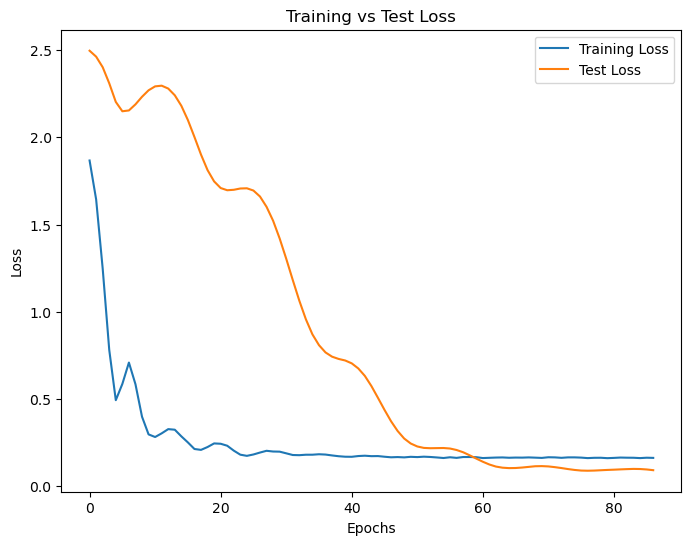

Loaded best model from epoch 77 for final evaluation.
Mean Squared Error: 0.0883
Mean Absolute Error: 0.2527


In [32]:
mse, mae, all_embeddings = train_gat(model, train_loader, test_loader, num_epochs=300, lr=0.0001, device=device)

In [51]:
node_embeddings, predicted_ratings = model.predict(test_data_obj.x, test_data_obj.edge_index, test_data_obj.edge_attr)


In [53]:
predicted_ratings

tensor([1.4205, 1.4224, 1.4224,  ..., 1.4198, 1.4224, 1.3899])

In [34]:
with open('../Pickle/gat_embeddings.pkl', 'wb') as f:
    pickle.dump(all_embeddings, f)

In [54]:
predictions = np.asarray(predicted_ratings, dtype=float)


In [55]:
predictions = denormalize_rating(predictions, min_rating)

In [56]:
def compute_precision_recall_f1(user_true_ratings, user_predictions, k, threshold=4): # books rated four and above are considered relevant
    precision_total, recall_total, f1_total = 0.0, 0.0, 0.0
    num_users = len(user_true_ratings)

    for user_id in user_true_ratings:
        if user_id not in user_predictions:
            continue  # Skip users without predictions

        # Get top-k predicted books
        top_k_pred = [book for book, _ in user_predictions[user_id][:k]]

        # Get relevant books from the true ratings (those with rating >= threshold)
        relevant_books = {book for book, rating in user_true_ratings[user_id] if rating >= threshold}

        # True positives: Items correctly recommended
        hits = sum(1 for book in top_k_pred if book in relevant_books)

        # Precision = Relevant items recommended / Total recommended
        precision = hits / k
        # Recall = Relevant items recommended / Total relevant items
        recall = hits / len(relevant_books) if len(relevant_books) > 0 else 0.0

        # F1-score calculation
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

        # Sum up for averaging
        precision_total += precision
        recall_total += recall
        f1_total += f1

    # Average across users
    precision_avg = precision_total / num_users
    recall_avg = recall_total / num_users
    f1_avg = f1_total / num_users

    return precision_avg, recall_avg, f1_avg

def compute_nDCG(user_true_ratings, user_predictions, k):
    nDCG_total = 0.0
    num_users = len(user_true_ratings)

    for user_id in user_true_ratings:
        if user_id not in user_predictions:
            continue  # Skip users without predictions

        # Get top-k predicted books
        top_k_pred = [book for book, _ in user_predictions[user_id][:k]]

        # Get actual ratings sorted by predicted order
        true_ratings_sorted = [rating for book, rating in user_true_ratings[user_id] if book in top_k_pred]

        # Compute DCG
        dcg = sum((2 ** rating - 1) / np.log2(i + 2) for i, rating in enumerate(true_ratings_sorted))

        # Compute ideal DCG (best possible ranking)
        ideal_ratings_sorted = sorted([rating for _, rating in user_true_ratings[user_id]], reverse=True)[:k]
        idcg = sum((2 ** rating - 1) / np.log2(i + 2) for i, rating in enumerate(ideal_ratings_sorted))

        # Normalize
        nDCG = dcg / idcg if idcg > 0 else 0.0
        nDCG_total += nDCG

    return nDCG_total / num_users

def evaluate_metrics(user_predictions, user_true_ratings, k=10):
    precision, recall, f1 = compute_precision_recall_f1(user_true_ratings, user_predictions, k)
    nDCG_score = compute_nDCG(user_true_ratings, user_predictions, k)

    print(f"Precision@{k}: {precision:.4f}")
    print(f"Recall@{k}: {recall:.4f}")
    print(f"F1-score@{k}: {f1:.4f}")
    print(f"nDCG@{k}: {nDCG_score:.4f}")

    return precision, recall, f1, nDCG_score

In [57]:
user_ids = test_data_obj.edge_index[0].cpu().numpy()  # Users in test set
book_ids = test_data_obj.edge_index[1].cpu().numpy()  # Books in test set

In [58]:
true_values = test_data_obj.edge_attr[:, 0].cpu().numpy()  # True ratings from the test data
true_values = np.expm1(true_values)  # Reverse np.log1p()

In [59]:
user_predictions = defaultdict(list)
user_true_ratings = defaultdict(list)

for i in range(len(predictions)):
    user_predictions[user_ids[i]].append((book_ids[i], predictions[i]))  # Store (book, predicted rating)
    user_true_ratings[user_ids[i]].append((book_ids[i], true_values[i]))  # Store (book, actual rating)

In [60]:
for user_id in user_predictions:
    user_predictions[user_id].sort(key=lambda x: x[1], reverse=True)  # Sort by predicted rating
    user_true_ratings[user_id].sort(key=lambda x: x[1], reverse=True)  # Sort by actual rating

In [63]:
precision, recall, f1, nDCG_score = evaluate_metrics(user_predictions, user_true_ratings, k=5)

Precision@5: 0.2532
Recall@5: 0.7855
F1-score@5: 0.3574
nDCG@5: 0.9936


In [64]:
def compute_mrr(user_predictions, user_true_ratings, threshold=4.0, k=10):
    mrr = 0.0
    user_count = 0

    for user_id in user_predictions:
        pred_books = [book for book, _ in user_predictions[user_id][:k]]  # Get top-K book IDs
        true_books = {book for book, rating in user_true_ratings[user_id] if rating >= threshold}  # Relevant books

        for rank, book in enumerate(pred_books, start=1):
            if book in true_books:  # Found a relevant book
                mrr += 1 / rank
                break  # Only consider the first relevant item
        
        user_count += 1  # Track valid users

    return mrr / user_count if user_count > 0 else 0.0  # Avoid division by zero

mrr_score = compute_mrr(user_predictions, user_true_ratings, threshold=4.5, k=5)
print(f"MRR@5: {mrr_score:.4f}")

MRR@5: 0.4154


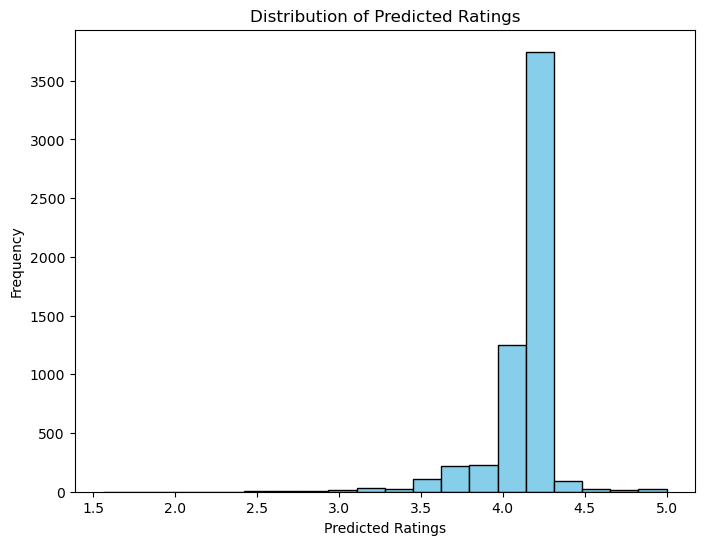

In [65]:
import matplotlib.pyplot as plt

def plot_prediction_histogram(predictions):
    plt.figure(figsize=(8, 6))
    plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Ratings')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_histogram(predictions)

In [66]:
predictions.min().item()

1.5580614285070222

In [67]:
predictions.max().item()

5.0

In [68]:
predictions.mean()

4.10037615989167

In [69]:
data['rating'].mean()

3.9301873094235518

In [70]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def visualize_embeddings_with_clustering(data_obj, embed_type="node", n_clusters=6):
    if embed_type == "node":
        embeddings = data_obj.x.cpu().detach().numpy()
        title = "PCA of Node Embeddings with Clusters"
    else:
        embeddings = data_obj.edge_attr.cpu().detach().numpy()
        title = "t-SNE of Edge Embeddings with Clusters"

    if embeddings.shape[1] > 2:  # Apply dimensionality reduction if needed
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    else:
        reduced_embeddings = embeddings

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_embeddings)
    labels = kmeans.labels_

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
    
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.colorbar(label="Cluster")
    plt.show()

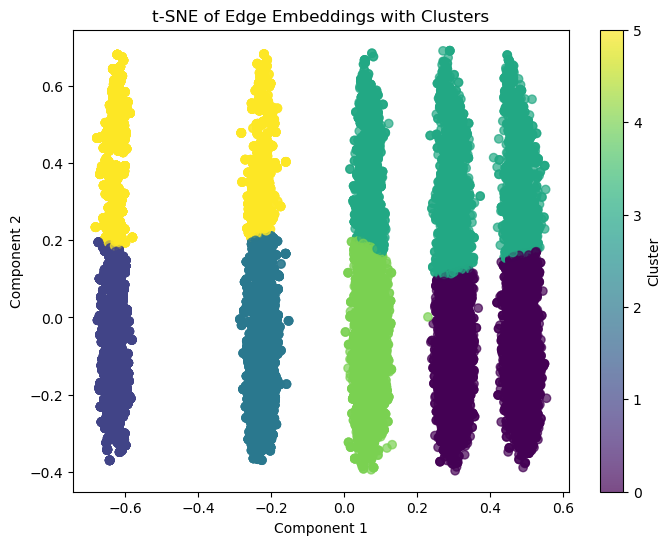

In [71]:
visualize_embeddings_with_clustering(train_data_obj, embed_type="edge")

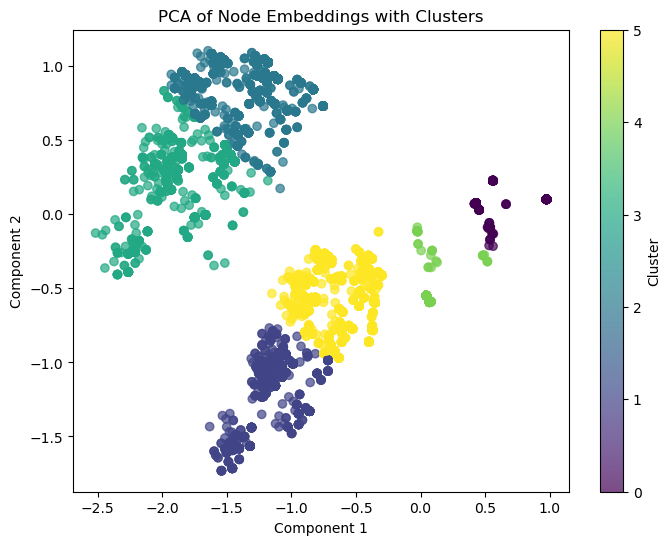

In [72]:
visualize_embeddings_with_clustering(train_data_obj, embed_type="node")

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_node_embeddings(user_genre_features, book_genre_features):
    # Convert user and book genre features into numpy arrays
    all_user_features = torch.stack(list(user_genre_features.values())).cpu().numpy()
    all_book_features = torch.stack(list(book_genre_features.values())).cpu().numpy()

    # Combine user and book features for dimensionality reduction
    all_features = np.concatenate([all_user_features, all_book_features], axis=0)

    # Option 1: Use PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_features_pca = pca.fit_transform(all_features)

    # Option 2: Use t-SNE for dimensionality reduction (can capture nonlinear relationships)
    tsne = TSNE(n_components=2)
    reduced_features_tsne = tsne.fit_transform(all_features)

    # Plot PCA reduced features
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], c='blue', label='Embeddings')
    plt.title("2D Projection of User and Book Features (PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

    # Plot t-SNE reduced features
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c='red', label='Embeddings')
    plt.title("2D Projection of User and Book Features (t-SNE)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.show()

In [ ]:
plot_node_embeddings(user_genre_features, book_genre_features)